# Baseline Deep-CF


In [2]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from tensorflow import keras
from tensorflow.keras import layers
from pandas import pandas as pd
import numpy as np

In [3]:
#----------METRICAS----------
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import average_precision_score,precision_score
from sklearn.metrics import recall_score

In [4]:
def rel(n):
    if n>0.5:
        return 1
    else:
        return 0
def precision(y_true,y_pred):

    result = y_true-y_pred
    print(result)

def mean_average_precision(y_pred,y_true):

    MAP = []
    N_total = len(y_pred)
    sumatoria_gen = 0.0

    for idx in  range(0,len(y_pred)):
        k = 7

        usuario_test = y_true[idx]
        alfa = 1
        array_7_res_true = {}
        for i in range(0,k):
            array_7_res_true[usuario_test[i][0]] = alfa
            alfa = alfa - 0.14

        usuario = y_pred[idx]
        array_7_res_pred = []

        for i in range(0,k):
            array_7_res_pred.append(usuario[i][0])
        
        sumatoria=0.0
        for place in array_7_res_pred:
            if place in array_7_res_true:
                sumatoria = sumatoria +1*array_7_res_true[place]
        MAP.append(sumatoria/k)
        sumatoria_gen+=sumatoria/k
    
    MAP_average = sumatoria_gen/N_total

    return MAP_average

In [5]:
def mean_reciprocal_rank(y_pred,y_true):
    sum_total = []
    for idx,value in enumerate(y_true):

        #Por usuario 
        array_true = {}
        idx = 0
        for indx, value in enumerate(value):
            place = value[0]
            array_true[place] = indx

        cont = 0
        sumatoria = 0
        for id_,value in enumerate(y_pred[idx],1):
            place_ = value[0]
            if cont<1:
                if place_ in  array_true and cont < 1 : 
                    sumatoria+= 1/id_
                    cont+=1
            else:
                break
        sum_total.append(sumatoria)
    #print(sum_total)
    return (sum(sum_total)/len(sum_total))

In [6]:
def precision_sr(y_pred,y_true):
    sum_total = []
    for idx,value in enumerate(y_true):

        #Por usuario 
        array_true = {}
        idx = 0
        for indx, value in enumerate(value,1):
            place = value[0]
            if indx<8:
                array_true[place] = indx

        cont = 0
        precision = 0
        intersection = 0
        for id_,value in enumerate(y_pred[idx],1):
            place_ = value[0]
            if id_<8:
                if place_ in  array_true : 
                    intersection +=1 
                cont+=1

        precision+= (intersection/cont)
            
        sum_total.append(precision)
    #print(sum_total)
    return (sum(sum_total)/len(sum_total))

In [7]:

from keras.layers import Input, Dense, concatenate

In [8]:
def read_dataset(path = './model_context_pref.csv'):
    dataset = pd.read_csv(path)
    return dataset

def preprocesing(dataset):
    
    user_poi = dataset.iloc[:, 1:3].values
    y = dataset.iloc[:,5:].values
    vocab_size = 300

    #input_ = []
    arr = np.empty((0,2), float)
    for raw in user_poi:
        user = one_hot(str(raw[0]), vocab_size)
        poi = one_hot(str(raw[1]), vocab_size)
        arr = np.vstack((arr, np.array([user[0],poi[0]])))
        #input_.append([user[0],poi[0]])

    return arr,y,user_poi

In [56]:
def model_etapa1(array_hidden_layers,input_,output): #selected the [128→64→32→16→8] hidden layers
    model = keras.Sequential() #model.add(Embedding(4, 8, input_length=32))
    model.add(layers.Dense(units = array_hidden_layers[0], kernel_initializer = 'uniform', activation = 'relu', input_dim = input_))

    for idx in range(1,len(array_hidden_layers)):
        model.add(layers.Dense(units = array_hidden_layers[idx] , kernel_initializer = 'uniform', activation = 'relu'))

    model.add(layers.Dense(units = output, kernel_initializer = 'uniform', activation = 'relu'))

    opt = keras.optimizers.Adam(learning_rate= 0.002)
    model.compile(loss='mean_squared_error', optimizer=opt) #metrics = ['accuracy']

    print(model.summary())
    #print("Number of weights after calling the model:", len(model.weights)) 
    return model

def dnn_etapa2(array_hidden_layers,input_,output): #selected the [128→64→32→16→8] hidden layers
    model = keras.Sequential() #model.add(Embedding(4, 8, input_length=32))
    model.add(layers.Dense(units = array_hidden_layers[0], kernel_initializer = 'uniform', activation = 'relu', input_dim = input_))

    for idx in range(1,len(array_hidden_layers)):
        model.add(layers.Dense(units = array_hidden_layers[idx] , kernel_initializer = 'uniform', activation = 'relu'))

    model.add(layers.Dense(units = output, kernel_initializer = 'uniform', activation = 'relu'))

    opt = keras.optimizers.Adam(learning_rate= 0.002)
    model.compile(loss='mean_squared_error', optimizer=opt) #metrics = ['accuracy']

    print("PESOS: ",model.load_weights)

    #keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

    print(model.summary())
    #model.fit(X_train, y_train, batch_size = 10, epochs = 50)
    #x = tf.ones((1, 4))
    #y = model(x)

    #y_pred = model.predict(X_test)

    #print(y_pred)
    return model
def recomendaciones(y_true,y_pred,user_id_test):
    dict_places = {'1p':0, '2p':1, '3p':2, '4p':3, '5p':4, '6p':5,'7p':6, '8p':7,'9p':8,'10p':9, '11p':10, '12p':11, '13p':12, '14p':13, '15p':14}
    N=7
    matriz_pred = np.zeros((19, 15))
    matriz_true = np.zeros((19, 15))

    for i in range(0,y_pred.shape[0]):
     
        score = y_pred[i][0]  #Se calculo 
        user  = user_id_test[i][0] #id de usuario 
        place  = dict_places[user_id_test[i][1]] #id del place 

        matriz_pred[user][place] = score
        matriz_true[user][place] = y_true[i]
    
    data_pred = pd.DataFrame(matriz_pred, columns = dict_places.keys())
    data_dict_pred = data_pred.to_dict('records')

    data_true = pd.DataFrame(matriz_true, columns = dict_places.keys())
    data_dict_true = data_true.to_dict('records')

    array_pred = []
    array_true = []

    for idx in range(0,len(data_dict_true)):
        array1 = data_dict_true[idx]
        array2 = data_dict_pred[idx]
       
        pred_ = sorted(array2.items(), key=lambda item: item[1], reverse=True)
        true_ = sorted(array1.items(), key=lambda item: item[1], reverse=True)

        array_pred.append(pred_[0:N])
        array_true.append(true_[0:N])

    return array_pred,array_true

# Deep-CF

In [10]:
def dnp_cf(array_hidden_layers,batch_size,epochs):

    #array_hidden_layers = [64,128,256] #64,128 #,32,64
    hidden_layers = array_hidden_layers.reverse() #[256,128,64] #64,128 #,32,64
    #batch_size = 256#512-256
    #epochs = 40
    output = 1

    #Cargar datos de entrenamiento 
    path_train = '../mod_recomendacion/datasetPropuesta/train.csv'
    dataset  = read_dataset(path_train)
    
    inputs_train,y,user_poi_train = preprocesing(dataset) #X y Y entrenamiento 
    """print("train->",inputs_train.shape)
    print("train->",y.shape)"""
    

    #Cargar datos de test
    path_test = '../mod_recomendacion/datasetPropuesta/test.csv'
    dataset_test  = read_dataset(path_test)
    inputs_test,y_test,user_poi_test = preprocesing(dataset_test) #X y Y entrenamiento 
    """print("test->",inputs_test.shape)
    print("test->",y_test.shape)"""
    

    #Train
    model1  = dnn_etapa2(array_hidden_layers,inputs_train.shape[1], 4)
    model1.fit(inputs_train, y, batch_size = batch_size, epochs = epochs)
    y_pred_mod1 = model1.predict(inputs_train)
    print("predict model1 : ",y_pred_mod1.shape)
    
    
    model2= dnn_etapa2(array_hidden_layers,y_pred_mod1.shape[1], 1)
    model2.fit(y_pred_mod1, y, batch_size = batch_size, epochs = epochs)
    y_pred_mod2 = model2.predict(y_pred_mod1)
    print("predict model2: ",y_pred_mod2.shape)


    #TEST
    
    y_pred_mod1_test = model1.predict(inputs_test)
    y_pred_mod2_test = model2.predict(y_pred_mod1_test)
    
    array_pred,array_true = recomendaciones(y_test,y_pred_mod2_test,user_poi_test)
    map_ = mean_average_precision(array_pred,array_true)
    mrk = mean_reciprocal_rank(array_pred,array_true)
    precision = precision_sr(array_pred,array_true)

    #print("-----------------------------------------------")
    #print("--------------------METRICAS ------------------")
    #print("-----------------------------------------------")

    mae  =  mean_absolute_error(y_test,y_pred_mod2_test)
    mse = mean_squared_error(y_test,y_pred_mod2_test)
    mape = mean_absolute_percentage_error(y_test,y_pred_mod2_test)
    

    
    print(" Error Medio Absoluto(MAE) : ", round(mae,3))
    print(" Error cuadratico medio (MSE) : ", round(mse,3)) 
    print(" Error Medio Absoluto(mape) : ", round(mape,3))
    print(" Error cuadratico medio (map_) : ", round(map_,3))
    print(" Error Medio Absoluto(mrk) : ", round(mrk,3))
    print(" Error cuadratico medio (precision) : ", round(precision,3))


    return [mae,mse,mape,map_,mrk,precision]


#dnp_cf()


# Main - Deep CF 

In [11]:
array_hidden_layers = [64,128,256,512] #64,128 #,32,64[8,16,32,64] 
batch_size = 512#512-256
epochs = 50
output = 1
hidden_layers = array_hidden_layers.reverse() #[256,128,64] #64,128 #,32,64

#Cargar datos de entrenamiento 
path_train = '../mod_recomendacion/datasetPropuesta/train.csv'
dataset  = read_dataset(path_train)
inputs_train,y,user_poi_train = preprocesing(dataset) #X y Y entrenamiento 
print(dataset)
    
    

     Unnamed: 0  userid  placeid      pref       act         y
0             0    1338   482954  0.255069  0.495435  0.351215
1             1    1338   580963  0.449491  0.651593  0.530332
2             2    1338   365256  0.788723  0.093860  0.510778
3             3    1338    89504  0.028347  0.835765  0.351315
4             4    1338  1267135  0.432767  0.762280  0.564572
..          ...     ...      ...       ...       ...       ...
495         495    5144    33631  0.540536  0.440251  0.500422
496         496    5144    27884  0.759855  0.842386  0.792867
497         497    5144    29835  0.228560  0.274565  0.246962
498         498    5144    27784  0.706262  0.411643  0.588414
499         499    5144    27784  0.130202  0.195311  0.156245

[500 rows x 6 columns]


In [12]:
#Cargar datos de test
path_test = '../mod_recomendacion/datasetPropuesta/test.csv'
dataset_test  = read_dataset(path_test)
inputs_test,y_test,user_poi_test = preprocesing(dataset_test) #X y Y entrenamiento 
print(dataset_test)

     Unnamed: 0  userid placeid      pref       act         y
0             0       0      1p  0.888889  0.833333  0.869444
1             1       0      2p  0.000000  0.833333  0.291667
2             2       0      3p  1.000000  0.833333  0.941667
3             3       0      4p  0.714286  0.833333  0.755952
4             4       0      5p  0.000000  0.833333  0.291667
..          ...     ...     ...       ...       ...       ...
280         280      18     11p  1.000000  2.333333  1.466667
281         281      18     12p  1.000000  1.583333  1.204167
282         282      18     13p  1.000000  2.333333  1.466667
283         283      18     14p  0.833333  1.583333  1.095833
284         284      18     15p  0.111111  3.000000  1.122222

[285 rows x 6 columns]


In [15]:
#Train
model1  = dnn_etapa2(array_hidden_layers,inputs_train.shape[1], 2)
model1.fit(inputs_train, y, batch_size = batch_size, epochs = epochs)
y_pred_mod1 = model1.predict(inputs_train)
print("predict model1 : ",y_pred_mod1.shape)
    
    
model2= dnn_etapa2(array_hidden_layers,y_pred_mod1.shape[1], 1)
model2.fit(y_pred_mod1, y, batch_size = batch_size, epochs = epochs)
y_pred_mod2 = model2.predict(y_pred_mod1)
print("predict model2: ",y_pred_mod2.shape)


#TEST
    
y_pred_mod1_test = model1.predict(inputs_test)
y_pred_mod2_test = model2.predict(y_pred_mod1_test)

array_pred,array_true = recomendaciones(y_test,y_pred_mod2_test,user_poi_test)


PESOS:  <bound method Model.load_weights of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9e540ff160>>
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
Total params: 174,146
Trainable params: 174,146
Non-trainable params: 0
_______________________________________________________

1/1 [==============================] - 0s 29ms/step - loss: 0.3082
Epoch 26/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3082
Epoch 27/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3082
Epoch 28/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3082
Epoch 29/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3082
Epoch 30/50
1/1 [==============================] - 0s 38ms/step - loss: 0.3082
Epoch 31/50
1/1 [==============================] - 0s 33ms/step - loss: 0.3082
Epoch 32/50
1/1 [==============================] - 0s 30ms/step - loss: 0.3082
Epoch 33/50
1/1 [==============================] - 0s 28ms/step - loss: 0.3082
Epoch 34/50
1/1 [==============================] - 0s 31ms/step - loss: 0.3082
Epoch 35/50
1/1 [==============================] - 0s 20ms/step - loss: 0.3082
Epoch 36/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3082
Epoch 37/50
1/1 [==============================] - 0s 21ms/step 

In [16]:
map_ = mean_average_precision(array_pred,array_true)
mrk = mean_reciprocal_rank(array_pred,array_true)
precision = precision_sr(array_pred,array_true)

#print("-----------------------------------------------")
#print("--------------------METRICAS ------------------")
#print("-----------------------------------------------")
mae  =  mean_absolute_error(y_test,y_pred_mod2_test)
mse = mean_squared_error(y_test,y_pred_mod2_test)
mape = mean_absolute_percentage_error(y_test,y_pred_mod2_test)
    

    
print(" MAE      : ", round(mae,3))
print(" MSE      : ", round(mse,3)) 
print(" MAPE     : ", round(mape,3))
print(" MAP      : ", round(map_,3))
print(" MRK      : ", round(mrk,3))
print(" Precision: ", round(precision,3))

 MAE      :  0.974
 MSE      :  1.057
 MAPE     :  1.0
 MAP      :  0.325
 MRK      :  0.796
 Precision:  0.511


# Test Movilents 

In [46]:

#Cargar datos de entrenamiento 
path_train = '../mod_recomendacion/datasetPropuesta/test_movilensTrain.csv'
dataset  = read_dataset(path_train)
print(dataset)

       Unnamed: 0  user       poi  rating      time
0               0   0.0  0.000000    1.00  0.012985
1               1   0.0  0.000595    0.50  0.116822
2               2   0.0  0.001190    0.75  0.205703
3               3   0.0  0.001785    0.50  0.116819
4               4   0.0  0.002380    0.50  0.809560
...           ...   ...       ...     ...       ...
79995       79995   1.0  0.634146    0.25  0.041861
79996       79996   1.0  0.638311    0.75  0.749682
79997       79997   1.0  0.706127    0.50  0.749682
79998       79998   1.0  0.729923    0.50  0.749683
79999       79999   1.0  0.790601    0.50  0.752495

[80000 rows x 5 columns]


In [47]:
inputs_train,y,user_poi_train = preprocesing(dataset) #X y Y entrenamiento 

In [48]:
y = dataset.iloc[:,3:4].values
y

array([[1.  ],
       [0.5 ],
       [0.75],
       ...,
       [0.5 ],
       [0.5 ],
       [0.5 ]])

In [49]:
#Cargar datos de test
path_test = '../mod_recomendacion/datasetPropuesta/test_movilensTest.csv'
dataset_test  = read_dataset(path_test)
inputs_test,y_test,user_poi_test = preprocesing(dataset_test) #X y Y entrenamiento 
print(dataset_test)


       Unnamed: 0      user       poi  rating      time
0               0  0.000000  0.003145    1.00  0.684917
1               1  0.000000  0.005660    0.50  0.052197
2               2  0.000000  0.006918    1.00  0.205802
3               3  0.000000  0.008176    1.00  0.012990
4               4  0.000000  0.010063    0.50  0.018783
...           ...       ...       ...     ...       ...
19995       19995  0.991323  0.406918    0.75  0.629073
19996       19996  0.991323  0.691824    0.75  0.629183
19997       19997  0.993492  0.586792    0.50  0.260817
19998       19998  0.995662  0.005660    0.50  0.441312
19999       19999  1.000000  0.428302    1.00  0.627420

[20000 rows x 5 columns]


In [50]:
y_test = dataset_test.iloc[:,3:4].values
y_test.shape

(20000, 1)

In [97]:
array_hidden_layers = [128,256,512] #64,128 #,32,64[8,16,32,64] 
batch_size = 256
epochs = 20
output = 1
hidden_layers = [256,128,64] #64,128 #,32,64

In [98]:
#Train
model1  = dnn_etapa2(array_hidden_layers,inputs_train.shape[1], 4)
model1.fit(inputs_train, y, batch_size = batch_size, epochs = epochs)
y_pred_mod1 = model1.predict(inputs_train)
print("predict model1 : ",y_pred_mod1.shape)
    
    
model2= dnn_etapa2(array_hidden_layers,y_pred_mod1.shape[1], 1)
model2.fit(y_pred_mod1, y, batch_size = batch_size, epochs = epochs)
y_pred_mod2 = model2.predict(y_pred_mod1)
print("predict model2: ",y_pred_mod2.shape)

PESOS:  <bound method Model.load_weights of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9da842ab20>>
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_115 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_116 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_117 (Dense)            (None, 4)                 2052      
Total params: 167,044
Trainable params: 167,044
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
313/313 [==============================] - 3s 10ms/step - loss: 0.3881
Epoch 2/20
313/313 [=============

In [99]:
#TEST
    
y_pred_mod1_test = model1.predict(inputs_test)
y_pred_mod2_test = model2.predict(y_pred_mod1_test)

#array_pred,array_true = recomendaciones(y_test,y_pred_mod2_test,user_poi_test)

In [100]:
y_pred_mod2_test

array([[0.62390846],
       [0.62390846],
       [0.62390846],
       ...,
       [0.62390846],
       [0.62390846],
       [0.62390846]], dtype=float32)

In [101]:
def rmse_(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [102]:
#print("-----------------------------------------------")
#print("--------------------METRICAS ------------------")
#print("-----------------------------------------------")
mae  =  mean_absolute_error(y_test,y_pred_mod2_test)
mse = mean_squared_error(y_test,y_pred_mod2_test)
#mape = mean_absolute_percentage_error(y_test,y_pred_mod2_test)
rmse = rmse_(y_test,y_pred_mod2_test)

#precision = precision_score(y_test,y_pred_mod2_test)
#recall = recall_score(y_test,y_pred_mod2_test, average='weighted')

print(" RMSE           : ", round(rmse,3)) 
#print(" precision      : ", round(precision,3)) 
#print(" recall         : ", round(recall,3)) 
print(" MSE            : ", round(mse,3)) 
print(" MAE            : ", round(mae,3))
#print(" MAPE           : ", round(mape,3))

 RMSE           :  0.289
 MSE            :  0.083
 MAE            :  0.243


In [104]:
array = [[5,0.288],[10, 0.696],[15, 0.696],[20,0.289]]

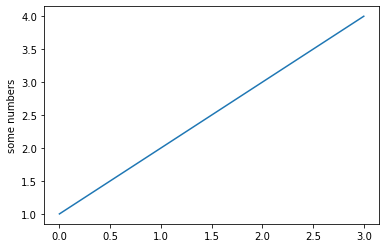

In [105]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

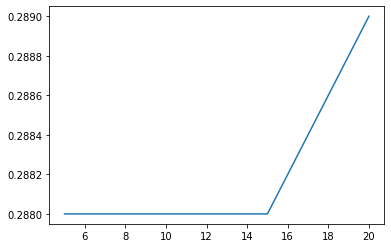

In [111]:
plt.plot([5, 10, 15, 20], [0.288, 0.288, 0.288, 0.289])
plt.show()